## LHC collective effects with Xsuite - part 2
* In this notebook we will study the TMCI threshold for a single bunch using the LHC impedance model at injection energy 
  *  **+ adding an additional contribution: 1700 unshielded LHC bellows** as a `WakeResonator` from the CST simulation result

<div style="text-align:center">
  <img src="data/wake-resonator.png" width="400">
</div>

* $\rightarrow$ [see A. Mostacci's CAS lecture](https://indico.cern.ch/event/1466612/contributions/6448530/)
  
*  The goal is to compare the beam dynamics with and without this contribution in the wake model
   *  ❓What is the new TMCI intensity threshold?
   *  ❓What are the means to mitigate the instability?
   *  ❓What do we observe in the intrabunch motion?

# What I want to highlight
* Overlap of the bunch and impedance spectrum causes instability growth rate, chromaticity can be used to shift the bunch spectrum to a preferable location
* Chromaticity introduces tune spread which translates into Landau damping. The tune distribution at low intensity can be used to highlight this effect when scanning chromaticity.

# Tasks
* Scan chromaticity until the beam is stable
* What is the effect of chromaticity on bunch spectrum?
* What is the effect of chromaticity on the tune distribution?
* When does it stabilize the beam? When does it destabilize the beam? Explain why.
* Is having a large chromaticity usually a good idea?

In [1]:
import os

import numpy as np
import pandas as pd
import h5py

import pickle

import xtrack as xt
import xpart as xp
import xwakes as xw
import xobjects as xo

from scipy.constants import c as clight

import matplotlib as mpl
import matplotlib.pyplot as plt


# !start-simulation-settings!

##### Machine parameters
circumference = 27000.0
machine_radius = circumference / (2*np.pi)

##### Parameters for the resistive wall wake
plane = 'x'
wake_type = 'dipolar'
wake_table = 'data/wake_lhc_injection.dat'

##### Initial offset to the particles x coordinate
initial_offset = 10.0e-6

##### Acceleration parameters
energy_gain_per_turn = 0
main_rf_phase = 180

##### RF parameters
h_RF = np.array([35640,])
V_RF = np.array([8.0e6])
dphi_RF = np.array([main_rf_phase,])
f_rev = 299792458 / circumference
omega_rev = 2*np.pi*f_rev
f_RF = np.array([f_rev*h for h in h_RF])

##### Optics parameters
alphap = 3.48e-4

Qx_frac = 0.275
Qy_frac = 0.295
Qx_int = 64
Qy_int = 59

Qx = Qx_int + Qx_frac
Qy = Qy_int + Qy_frac

##### Chromaticity
chromaticity = 0
print('Qp:', chromaticity)

##### Bunch parameters
p0c = 450.0e9
bucket_length = circumference / h_RF[0]
nemitt_x = 2.0e-6
nemitt_y = 2.0e-6
taub = 1.0e-9    # Full bunch length (4*sigma_z)
sigma_z = taub * clight / 4

# We use a limited amount of MP to have a general view of the wake effects
n_macroparticles = int(10_000)
num_slices = int(100)

# Bunch intensity scan
delta_bint = 3e10
#bunch_intensity_scan = np.arange(1e9, 5e11, delta_bint, )
bunch_intensity_scan = np.linspace(1e9, 5e11, 5)
print('Bunch intensity scan:', bunch_intensity_scan)

# Number of turns simulated
number_of_turns = 1_000

# Save or not some plots (wakefield, emittance growth)
flag_plot = True

# Restart tracking simulations even if they were already done
flag_restart_sim = True

# Create the reference particle for xtrack
reference_particle = xt.Particles(mass0=xp.PROTON_MASS_EV, p0c=p0c)
beta0 = reference_particle.beta0[0]
gamma0 = reference_particle.gamma0[0]

# !end-simulation-settings!

Qp: 0
Bunch intensity scan: [1.0000e+09 1.2575e+11 2.5050e+11 3.7525e+11 5.0000e+11]


# Generate wake function and impedance

In [2]:
# Load the base HLLHC wake at injection 
#wake_hllhc = xw.read_headtail_file(wake_table, ['time', 'dipole_x', 'dipole_y', 'quadrupolar_x', 'quadrupolar_y'])
#wake_for_tracking_hllhc = xw.WakeFromTable(table=wake_hllhc, columns=['dipole_x'])

time_sampling = np.concatenate((
    [0],
    np.linspace(1e-14, 1e-11, 2000),
    np.geomspace(1e-11, 1e-3, 1000)
))

# values taken from David's PhD, p60
wake_RW = xw.WakeThickResistiveWall(resistivity=1.7e-8, radius=1e-2, length=circumference,
                                   kind='dipolar_x')
wake_RW_arr = wake_RW.components[0].function_vs_t(time_sampling, beta0=beta0, dt=1e-15)

# values taken from David's PhD, p76
wake_BBR = xw.WakeResonator(r=25e6, q=1, f_r=8e9, kind='dipolar_x')
wake_BBR_arr = wake_BBR.components[0].function_vs_t(time_sampling, beta0=beta0, dt=1e-15)
wake_LHC_df = pd.DataFrame({'time': time_sampling, 'dipole_x': wake_RW_arr + wake_BBR_arr})

### Adding the LHC bellows impedance
* We add it (in time-domain) as a dipolar broadband resonator wake with the shunt impedance $R_s$ in $\Omega/m$ calculated in the CST simulation

In [3]:
# Adding a resonator
Rs = 5e0
Q = 500
fr = 1e9
wake_resonator = xw.WakeResonator(r=Rs, q=Q, f_r=fr, kind='dipolar_x')
wake_resonator_arr = wake_resonator.components[0].function_vs_t(time_sampling, beta0=beta0, dt=1e-15)
wake_resonator_df = pd.DataFrame({'time': time_sampling, 'dipole_x': wake_resonator_arr})

In [4]:
#### Configure the wake for tracking
wake_for_tracking = wake_RW + wake_BBR + wake_resonator
component_names = ['RW', 'BBR', 'Resonator']

wake_for_tracking.configure_for_tracking(
    zeta_range=(-0.375, 0.375),
    num_slices=num_slices,
    circumference=circumference,
    num_turns=1,
)

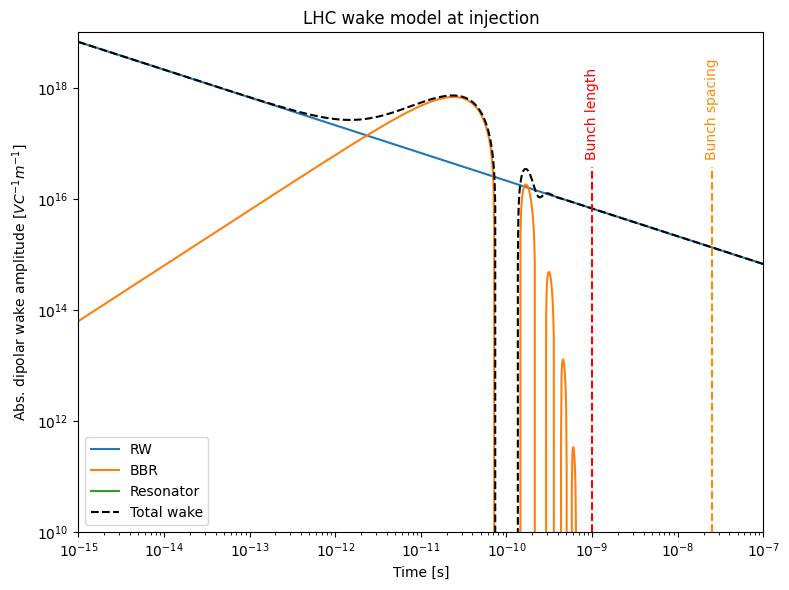

In [5]:
time_array = np.geomspace(1e-15, 1e-3, 2000)
sum_wake_for_tracking = np.zeros_like(time_array)

# Plot the wake model
if True:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    for ii_component, component in enumerate(wake_for_tracking.components):
        
        component_to_plot = component.components[0].function_vs_t(time_array, beta0=beta0, dt=1e-15)
        ax.plot(time_array, component_to_plot, label=component_names[ii_component])

        sum_wake_for_tracking += component_to_plot
    
    ax.plot(time_array, sum_wake_for_tracking, label='Total wake', color='black', linestyle='--')

    ax.axvline(1.e-9, ymax=0.73, c='r', ls='--')
    ax.axvline(25.e-9,  ymax=0.73, c='darkorange', ls='--')

    # Add text annotations above each line
    ax.text(1.e-9, 5e16, 'Bunch length', color='r', ha='center', va='bottom', rotation=90)
    ax.text(25.e-9, 5e16, 'Bunch spacing', color='darkorange', ha='center', va='bottom', rotation=90)

    ax.legend()

    ax.set_title('LHC wake model at injection')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Abs. dipolar wake amplitude [$V C^{-1} m^{-1}$]')

    ax.set_xlim(1e-15, 1e-7)
    ax.set_ylim(1e10, 1e19)
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.savefig('002_wake_for_tracking.png')

In [6]:
frequency_array = np.linspace(1e3, 10e9, 5000)
wake_for_tracking.components[0].components[0].impedance(frequency_array)

array([3.35937940e+09+3.35937940e+09j, 7.50917318e+07+7.50917318e+07j,
       5.31045066e+07+5.31045066e+07j, ...,
       1.06254162e+06+1.06254162e+06j, 1.06243531e+06+1.06243531e+06j,
       1.06232904e+06+1.06232904e+06j])

In [7]:
def sample_omega_k(m, n, M, kmax=20):
    #m = 0 # azimutal number
    #n = 0 # coupled-bunch number
    k = np.arange(-kmax, kmax, 1)
    p = k + n*M
    return (p + Qx_frac)*omega_rev

def hmm(m_mode, omega, bunch_length_seconds):
    """
    Compute hmm power spectrum of Sacherer formula, for azimuthal mode number m,
    at angular frequency 'omega' (rad/s) (can be an array), for total bunch length
    'bunch_length_seconds' (s), and for a kind of mode specified by 'mode_type'
    (which can be 'hermite' or 'sinusoidal')
    :param m_mode: the azimuthal mode number
    :param omega: the angular frequency at which hmm is computed
    """
    # best for protons
    hmm_val = (((bunch_length_seconds * (np.abs(m_mode) + 1.)) ** 2 / (2. * np.pi ** 4)) *
               (1. + (-1) ** m_mode * np.cos(omega * bunch_length_seconds)) /
               (((omega * bunch_length_seconds / np.pi) ** 2 - (np.abs(m_mode) + 1.) ** 2) ** 2))
    return hmm_val / hmm_val.max()

In [8]:
chromaticity

0

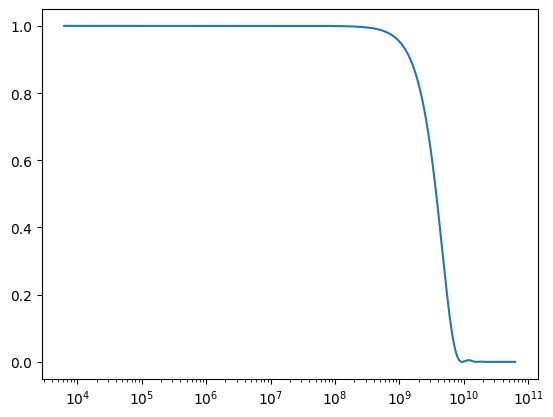

In [9]:
omega_k = sample_omega_k(0, 0, h_RF, 50000)

omega = 2 * np.pi * frequency_array
omega_ksi = 1*chromaticity * omega_rev / 0.0003436917737167526#eta

plt.figure()
plt.plot(omega, hmm(0, omega - omega_ksi, taub))
#plt.stem(omega_k - omega_ksi, hmm(0, omega_k - omega_ksi, taub), markerfmt='')
plt.xscale('log')

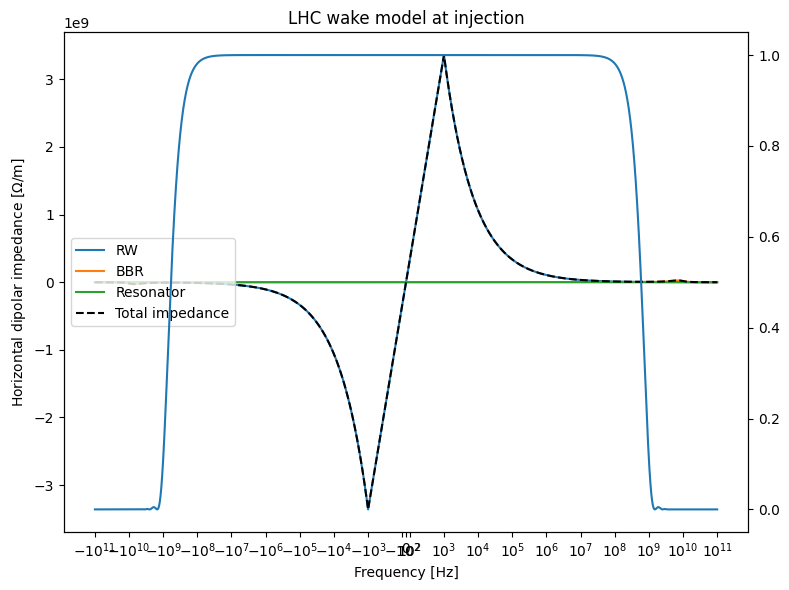

In [33]:
#frequency_array = np.geomspace(1e3, 1e11, 5000)
frequency_array = np.concatenate((np.geomspace(-1e11, -1e3, 2500), np.geomspace(1e3, 1e11, 2500)))
sum_imp_for_tracking = np.zeros_like(frequency_array, dtype=complex)

# Plot the impedance model
if True:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    for ii_component, component in enumerate(wake_for_tracking.components):
        
        component_to_plot = component.components[0].impedance(frequency_array)
        ax.plot(frequency_array, component_to_plot, label=component_names[ii_component])

        sum_imp_for_tracking += component_to_plot
    
    ax.plot(frequency_array, sum_imp_for_tracking, label='Total impedance', color='black', linestyle='--')

    #ax.axvline(1/1e-9, ymax=0.73, c='r', ls='--')
    #ax.axvline(1/25e-9,  ymax=0.73, c='darkorange', ls='--')

    # Add text annotations above each line
    #ax.text(1/1.e-9, 5e16, 'Bunch length', color='r', ha='center', va='bottom', rotation=90)
    #ax.text(1/25.e-9, 5e16, 'Bunch spacing', color='darkorange', ha='center', va='bottom', rotation=90)

    ax.legend(loc='center left')

    ax.set_title('LHC wake model at injection')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Horizontal dipolar impedance [$\Omega$/m]')

    #ax.set_xlim(1e-15, 1e-7)
    #ax.set_ylim(1e10, 1e19)
    ax.set_xscale('symlog', linthresh=1e3)
    #ax.set_yscale('symlog', linthresh=1e6)
    
    axbis = ax.twinx()
    axbis.plot(frequency_array, hmm(0, 2*np.pi*frequency_array - omega_ksi, taub))
    #axbis.set_ylim(-1, 2)

    plt.tight_layout()
    #plt.savefig('002_wake_for_tracking.png')

In [29]:
omega

array([6.28318531e+03, 1.25751663e+07, 2.51440495e+07, ...,
       6.28067153e+10, 6.28192842e+10, 6.28318531e+10])

In [11]:
# The line for Q' = 0 will be used for the twiss
segment_map = xt.LineSegmentMap(
    length=circumference,
    betx=machine_radius/Qx, bety=machine_radius/Qy,
    dnqx=[Qx_frac, 0], dnqy=[Qy_frac, 0],
    longitudinal_mode='linear_fixed_rf',
    voltage_rf=V_RF, frequency_rf=f_RF,
    lag_rf=dphi_RF, momentum_compaction_factor=alphap
    )


# Construct the full OTM with line segments and WF elements
one_turn_map_elements = [segment_map,]

# Compile the line
reference_line = xt.Line(one_turn_map_elements)
reference_line.particle_ref = reference_particle

# Compute the twiss parameters
tw = reference_line.twiss()
Qs = tw.qs
eta = tw.slip_factor
print(f'Qs = {Qs}, eta = {eta}')

Qs = 0.005886788114278452, eta = 0.0003436917737167526


In [12]:
%%capture --no-display --no-stdout

results_folder = f'bunchmonitor_data_hllhc_with_bellows'
for bunch_intensity in bunch_intensity_scan:
    print(f'Simulation for b_int = {bunch_intensity:.2e}')

    if (not os.path.isfile(f'./{results_folder}/bunchmonitor_bint_{bunch_intensity:.2e}_bunches.h5')) or flag_restart_sim:
        print(f'File {results_folder}/bunchmonitor_bint_{bunch_intensity:.2e}_bunches.h5 not found or flag_restart_sim active, starting simulation')
        os.makedirs(f'./{results_folder}', exist_ok=True)

        segment_map = xt.LineSegmentMap(
            length=circumference,
            betx=machine_radius/Qx, bety=machine_radius/Qy,
            dnqx=[Qx_frac, chromaticity], dnqy=[Qy_frac, chromaticity],
            longitudinal_mode='linear_fixed_rf',
            voltage_rf=V_RF, frequency_rf=f_RF,
            lag_rf=dphi_RF, momentum_compaction_factor=alphap
            )


        # Create monitors at each RF station
        # initialize a monitor for the average transverse positions
        flush_data_every = int(500)
        particle_monitor_mask = np.full(n_macroparticles, False, dtype=bool)
        particle_monitor_mask[0:5] = True
            
        monitor = xw.CollectiveMonitor(
            base_file_name=f'./{results_folder}/bunchmonitor_bint_{bunch_intensity:.2e}',
            monitor_bunches=True,
            monitor_slices=True,
            monitor_particles=False,
            particle_monitor_mask=particle_monitor_mask,
            flush_data_every=flush_data_every,
            stats_to_store=['mean_x', 'mean_y', 'mean_px', 'sigma_x', 'epsn_x', 'num_particles'],
            stats_to_store_particles=['x', 'px'],
            backend='hdf5',
            zeta_range=(-0.3*bucket_length, 0.3*bucket_length),
            num_slices=num_slices//2,
            bunch_spacing_zeta=circumference,
        )

        # Construct the full OTM with line segments and WF elements
        one_turn_map_elements = [monitor, segment_map, wake_for_tracking]

        # Compile the line
        line = xt.Line(one_turn_map_elements)
        line.particle_ref = reference_particle
        line.build_tracker()

        # initialize a matched gaussian bunch
        particles = xp.generate_matched_gaussian_bunch(
            num_particles=n_macroparticles,
            total_intensity_particles=bunch_intensity,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y,
            sigma_z=sigma_z,
            line=line,
        )

        # apply a kick to the particles
        particles.x += initial_offset

        turn_range = np.arange(0, number_of_turns, 1)

        # Track
        line.track(particles, num_turns=number_of_turns, with_progress=True)
    
    else:
        print(f'File bunchmonitor_bint_{bunch_intensity:.2e}.h5 found, skipping simulation')

Simulation for b_int = 1.00e+09
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_1.00e+09_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Simulation for b_int = 1.26e+11
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_1.26e+11_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation for b_int = 2.50e+11
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_2.50e+11_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation for b_int = 3.75e+11
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_3.75e+11_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation for b_int = 5.00e+11
File bunchmonitor_data_hllhc_with_bellows/bunchmonitor_bint_5.00e+11_bunches.h5 not found or flag_restart_sim active, starting simulation


Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

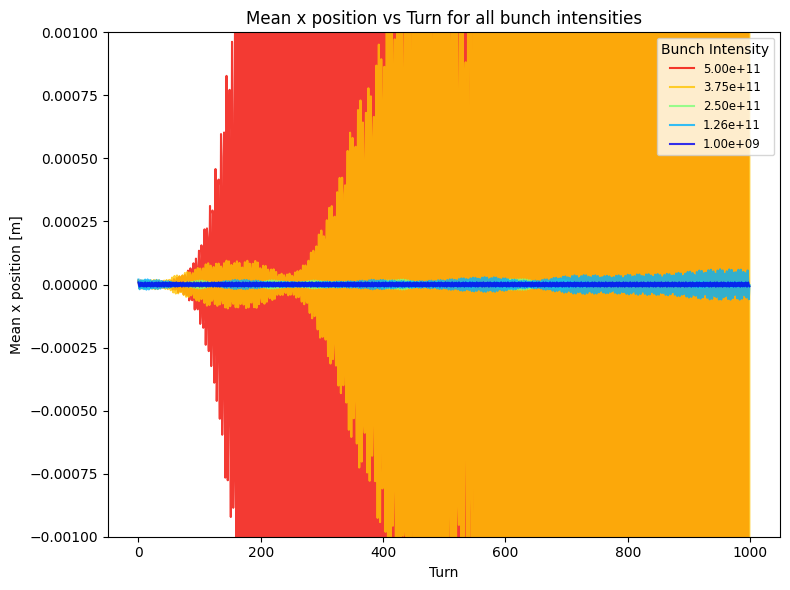

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.9, 0.1, len(bunch_intensity_scan)))

for i, bint in enumerate(reversed(bunch_intensity_scan)):
    file_path = f'./{results_folder}/bunchmonitor_bint_{bint:.2e}_bunches.h5'
    try:
        with h5py.File(file_path, 'r') as h5file:
            mean_x = h5file['0']['mean_x'][:]
            ax.plot(np.real(mean_x), color=colors[i], label=f'{bint:.2e}', alpha=0.8)
    except FileNotFoundError:
        print(f'File not found: {file_path}')

ax.set_ylim(-1e-3, 1e-3)
ax.set_yscale('linear')
ax.set_xlabel('Turn')
ax.set_ylabel('Mean x position [m]')
ax.set_title('Mean x position vs Turn for all bunch intensities')
ax.legend(title='Bunch Intensity', fontsize='small', loc='best')
fig.tight_layout()
plt.savefig('002_turn_by_turn_data_all_bints.png')
plt.show()

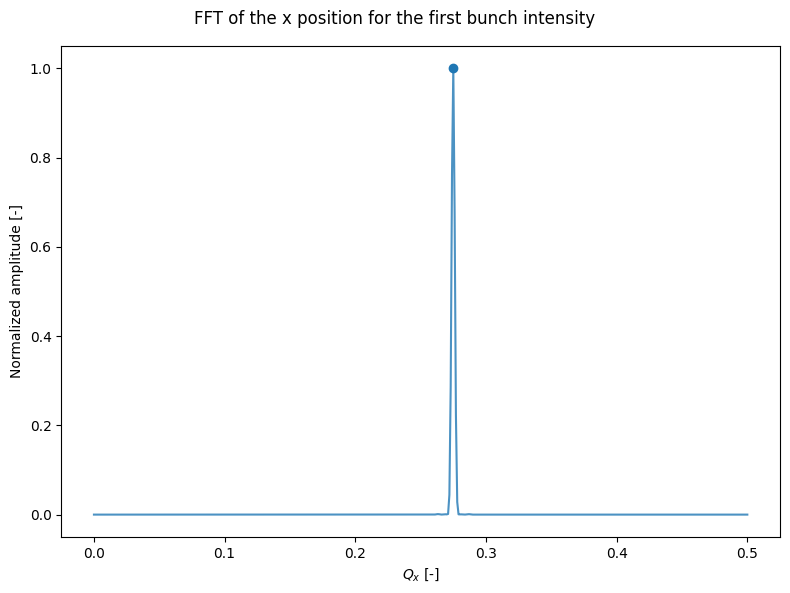

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

n_turns_fft = number_of_turns
window = np.kaiser(n_turns_fft, beta=14)

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.1, 0.9, len(bunch_intensity_scan)))

file_path = f'./{results_folder}/bunchmonitor_bint_{bunch_intensity_scan[0]:.2e}_bunches.h5'
try:
    with h5py.File(file_path, 'r') as h5file:
        mean_x = h5file['0']['mean_x'][:]
        if len(mean_x) >= n_turns_fft:
            x_values = np.fft.rfftfreq(n_turns_fft, d=1.0)
            y_values = np.abs(np.fft.rfft(mean_x[-n_turns_fft:] * window))
            y_norm = y_values / np.max(y_values)
            ax.plot(x_values, y_norm, label=f'{bunch_intensity_scan[0]:.2e}', alpha=0.8)
            ax.scatter(x_values[np.argmax(y_values)], 1, zorder=10)
        else:
            print(f'Not enough turns for FFT in file: {file_path}')
except FileNotFoundError:
    print(f'File not found: {file_path}')

ax.set_xlabel('$Q_x$ [-]')
ax.set_ylabel('Normalized amplitude [-]')
#ax.set_xlim(0.24, 0.3)
#ax.set_ylim(-0.1, 1.1)
#ax.legend(title='Bunch Intensity', fontsize='small', loc='best')
fig.suptitle('FFT of the x position for the first bunch intensity')
fig.tight_layout()
plt.savefig('002_fft_x_position_all_bints.png')
plt.show()